In [1]:
import yt
import numpy as np
import matplotlib.pyplot as plt
from numpy import fft

In [2]:
savedir = "./"
L = 32
start = 5
ideal = 0
binsize = L//2 - 1
correlated = True

kappa = 0.01
kbt = 1e-7
u0 = 0
cs2 = 1/3
gamma = 1.0
Lambda = 1.1
T = 0.6

# Helper functions

In [3]:
def lattice_fourier_laplacian(kx, ky, kz):
    expr1 = np.cos(kx) + np.cos(ky) + np.cos(kz)
    expr2 = np.cos(kx)*np.cos(ky) + np.cos(ky)*np.cos(kz) + np.cos(kx)*np.cos(kz)
    out = 2/9*expr1 + 2/9*expr2 - 4/3
    return -out/cs2

def thermal_cs2(rho):
    # square_term = (rho - rhol)*(rho - rhov)
    # expr1 = Beta*square_term*(rhol - rhov - 6*rho)
    # expr2 = Beta*(rho - rhol)*(2*rho*(rhol + rhov - 2*rho) + square_term)
    # expr3 = Beta*(rho - rhov)*(2*rho*(rhol + rhov - 2*rho) + square_term)
    # return -expr1 - expr2 - expr3
    return cs2

def cs2k(density, kx, ky, kz):
    if correlated:
        out = thermal_cs2(density) + lattice_fourier_laplacian(kx, ky, kz)*kappa*rho0
    else:
        out = thermal_cs2(density)
    return out

In [4]:
def spherically_averaged_structure_factor(data, density, scale_factor = 1, func = None, shift = True):
    L = min(data.shape)
    S = data.copy()

    if shift:
        freqs = fft.fftshift(fft.fftfreq(L))
    else:
        freqs = fft.fftfreq(L)
    if len(data.shape) == 3:
        kx, ky, kz = np.meshgrid(*tuple([2*np.pi*freqs for L in [L, L, L]]), indexing='ij')
        k = np.stack([kx, ky, kz], axis = -1)
    elif len(data.shape) == 2:
        kx, ky = np.meshgrid(*tuple([2*np.pi*freqs for L in [L, L]]), indexing='ij')
        k = np.stack([kx, ky], axis = -1)
     
    k1 = np.linalg.norm(k, axis=-1).flatten()
    
    if func is not None:
         S = func(S, cs2k(density, kx, ky, kz))
    S /= scale_factor

    S1 = S.flatten()
    kmin = 2*np.pi/L # sampling frequency
    where = np.s_[:]#np.where(k1<=kmax)
    bins = np.arange(L//2+1)*kmin # kmax+1 for bin_edges: len(bins)=len(hist)+1
    
    shells = np.histogram(k1[where], bins, weights=S1[where])[0]
    counts = np.histogram(k1[where], bins)[0]
    return (bins[:-1]+bins[1:])/2, shells/counts

In [5]:
def cart2sph(x,y,z):
    azimuth = np.arctan2(y,x)
    elevation = np.arctan2(z,np.sqrt(x**2 + y**2))
    r = np.sqrt(x**2 + y**2 + z**2)
    return r, azimuth, elevation

def sph2cart(azimuth,elevation,r):
    x = r * np.cos(elevation) * np.cos(azimuth)
    y = r * np.cos(elevation) * np.sin(azimuth)
    z = r * np.sin(elevation)
    return x, y, z

def radial_equilibration(data, density, radius = 1, scale_factor = 1, func = None):
    S = data.copy()
    L = min(S.shape)
    freqs = fft.fftshift(fft.fftfreq(L))
    kx, ky, kz = np.meshgrid(*tuple([2*np.pi*freqs for L in [L, L, L]]), indexing='ij')

    r, t, p = cart2sph(kx, ky, kz)

    if func is not None:
        S = func(S, cs2k(density, kx, ky, kz))
    S /= scale_factor

    idxs = np.isclose(r, radius, atol = 2*np.pi/L)
    t = t[idxs]
    p = p[idxs]
    out = S[idxs]

    return t, p, out

In [6]:
def make_bins(to_bin1, binsize, to_bin2 = None):
    bins = np.linspace(to_bin1.min(), to_bin1.max(), binsize)

    out1 = np.zeros(binsize)
    shell = np.digitize(to_bin1, bins = bins, right = True)
    np.add.at(out1, shell, to_bin1)
    unique, counts = np.unique(shell, return_counts=True)
    out1 = out1[unique]
    out1 /= counts

    if to_bin2 is None:
        return bins, out1
    else:
        out2 = np.zeros(binsize)
        np.add.at(out2, shell, to_bin2)
        unique, counts = np.unique(shell, return_counts=True)
        out2 = out2[unique]
        out2 /= counts
        return out1, out2

# Validation

## Equilibration ratios

In [10]:
idx = -1
rho_data = 1.0
ts = yt.load(savedir+"SF_plt_mag*")
ds = ts[idx]
ad = ds.all_data()

yt : [INFO     ] 2024-07-26 13:28:15,060 Parameters: current_time              = 1000.0
yt : [INFO     ] 2024-07-26 13:28:15,060 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2024-07-26 13:28:15,061 Parameters: domain_left_edge          = [-100.53096491 -100.53096491 -100.53096491]
yt : [INFO     ] 2024-07-26 13:28:15,062 Parameters: domain_right_edge         = [100.53096491 100.53096491 100.53096491]


In [11]:
ds.field_list

[('boxlib', 'struct_fact_density_density'),
 ('boxlib', 'struct_fact_density_phi'),
 ('boxlib', 'struct_fact_density_ux'),
 ('boxlib', 'struct_fact_density_uy'),
 ('boxlib', 'struct_fact_density_uz'),
 ('boxlib', 'struct_fact_phi_phi'),
 ('boxlib', 'struct_fact_phi_ux'),
 ('boxlib', 'struct_fact_phi_uy'),
 ('boxlib', 'struct_fact_phi_uz'),
 ('boxlib', 'struct_fact_ux_ux'),
 ('boxlib', 'struct_fact_ux_uy'),
 ('boxlib', 'struct_fact_ux_uz'),
 ('boxlib', 'struct_fact_uy_uy'),
 ('boxlib', 'struct_fact_uy_uz'),
 ('boxlib', 'struct_fact_uz_uz')]

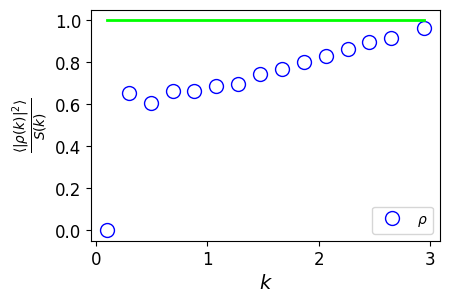

In [12]:
data = [np.array(ad[('boxlib', 'struct_fact_density_density')]).reshape(L, L, L)]

ar = 1.5
sz = 3
fig, ax = plt.subplots(1, 1, figsize = (sz*ar, sz))

colors = ['b', "r", "k"]
markers = ["o", "s", '^']
labels = [r"$\rho$"]

rho_scale = lambda a, c: a*c
scale_factor = 1

for d in data:
        x, y = spherically_averaged_structure_factor(d, rho_data, scale_factor = scale_factor, func = rho_scale)
        x, y = make_bins(x, binsize, to_bin2 = y)
        ax.plot(x, y, 
                marker = markers[0], color = colors[0],
                markerfacecolor = "None", markersize = 10, 
                linestyle = "None", label = labels[0])

ax.plot(x, [1]*x.size, 'lime', lw = 2)

ax.set_xlabel(r"$k$", fontsize = 14)
ax.set_ylabel(r"$\frac{ \langle | \rho(k) | ^2 \rangle }{S(k)}$", fontsize = 14)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='both', which='minor', labelsize=10)
ax.legend()
# ax.set_ylim([0.9, 1.1])

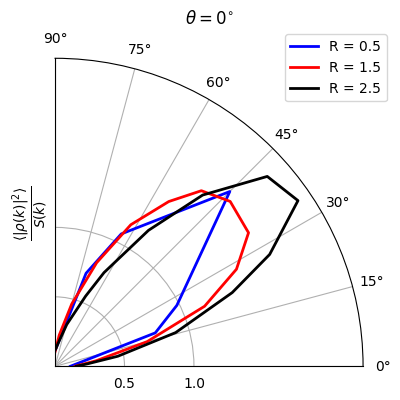

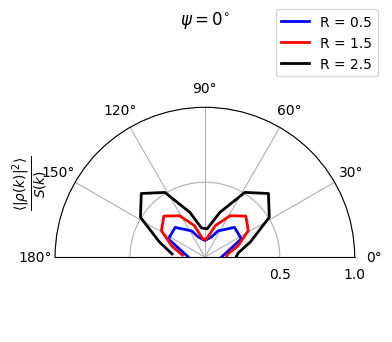

In [13]:
sz = 4
fig, tax = plt.subplots(1, 1, figsize = (sz, sz), subplot_kw={'projection': 'polar'})
fig, pax = plt.subplots(1, 1, figsize = (sz, sz), subplot_kw={'projection': 'polar'})

colors = ['b', "r", "k"]
markers = ["o", "s", '^']

radii = [0.5, 1.5, 2.5]

t_angle = 0
p_angle = 0 
# binsize = 10

# rho_scale = None
# scale_factor = 1/cs2

for d in data:
    ax1 = tax
    ax2 = pax
    for i, r in enumerate(radii):
        t, p, sf = radial_equilibration(d, rho_data, radius = r, func=rho_scale, scale_factor = scale_factor)

        idxs = np.isclose(np.abs(t), t_angle/180*np.pi, atol = np.pi/L)
        angles = np.abs(p)[idxs]
        segment = sf[idxs]
        angles, segment =  make_bins(angles, binsize, to_bin2 = segment)
        ax1.plot(angles, segment, color = colors[i], label = f"R = {r}",lw = 2)

        idxs = np.isclose(np.abs(p), p_angle/180*np.pi, atol = np.pi/L)
        angles = np.abs(t)[idxs]
        segment = sf[idxs]
        angles, segment =  make_bins(angles, binsize, to_bin2 = segment)
        ax2.plot(angles, segment, color = colors[i], label = f"R = {r}",lw = 2)


    ax1.set_rticks([0.5, 1.0])
    ax1.set_thetalim([0, np.pi/2])
    ax1.set_ylabel(r"$\frac{ \langle | \rho(k) | ^2 \rangle }{S(k)}$", fontsize = 14)
    ax1.legend(loc = 'upper right', bbox_to_anchor=(1.1, 1.1), fancybox=True)
    ax1.set_title(r"$\theta = {{{0}}}^{{\circ}}$".format(t_angle))

    ax2.set_rticks([0.5, 1.0])
    ax2.set_thetalim([0, np.pi])
    ax2.set_ylabel(r"$\frac{ \langle | \rho(k) | ^2 \rangle }{S(k)}$", fontsize = 14)
    ax2.legend(loc = 'upper right', bbox_to_anchor=(1.1, 1.1), fancybox=True)
    ax2.set_title(r"$\psi = {{{0}}}^{{\circ}}$".format(p_angle))

fig.tight_layout()